In [219]:
import pandas as pd

In [220]:
# Load the saved datasets
final_fire_data = pd.read_csv("final_fire_data.csv")
demographic_data = pd.read_csv("demographic_data.csv")


In [221]:
# Convert ZIP code to string and pad if needed
final_fire_data["ZIP_CODE"] = final_fire_data["ZIP_CODE"].astype(str).str.zfill(5)
demographic_data["ZIP_CODE"] = demographic_data["ZIP_CODE"].astype(str).str.zfill(5)

# Convert year to int (if needed)
final_fire_data["YEAR_"] = final_fire_data["YEAR_"].astype(int)
demographic_data["YEAR"] = demographic_data["YEAR"].astype(int)


In [222]:
final_fire_data.shape

(2014, 7)

In [223]:
merged_data = pd.merge(
    demographic_data,
    final_fire_data,
    left_on=["ZIP_CODE", "YEAR"],
    right_on=["ZIP_CODE", "YEAR_"],
    how="left",
    indicator=True
)

merged_data["_merge"].value_counts()

_merge
left_only     22424
both           1871
right_only        0
Name: count, dtype: int64

In [224]:
unmatched_zips = final_fire_data.loc[
    ~final_fire_data["ZIP_CODE"].isin(demographic_data["ZIP_CODE"].unique()),
    "ZIP_CODE"
].value_counts()

unmatched_zips # 14 zips aren't included in demographic dataset 
# those 14 ZIPs’ rows in the fire data are dropped in the final merge result, because we're joining from demographic ZIPs only (left join), and those 14  ZIPs don’t exist there.

ZIP_CODE
93633    11
95364     6
91980     5
95915     5
95679     4
92055     3
93262     3
95972     2
92096     1
92267     1
92304     1
93042     1
95721     1
Name: count, dtype: int64

In [225]:
# Create a flag column for fire exposure
# 0 means no
# 1 means yes
merged_data["FIRE_EXPOSED"] = (merged_data["_merge"] == "both").astype(int)



In [226]:
merged_data.shape

(24295, 22)

In [227]:
#######  Create Target Value: PCT_PRICE_CHANGE ###########

# Step 1: Sort by ZIP and Year
merged_data = merged_data.sort_values(by=["ZIP_CODE", "YEAR"])

# Step 2: Compute next year’s median home value per ZIP
merged_data["NEXT_YEAR_PRICE"] = (
    merged_data.groupby("ZIP_CODE")["PRICE"].shift(-1)
)

# Step 3: Compute price change
merged_data["PRICE_CHANGE"] = (
    merged_data["NEXT_YEAR_PRICE"] - merged_data["PRICE"]
)

# Step 4: Compute percent price change
merged_data["PCT_PRICE_CHANGE (%)"] = (
    merged_data["PRICE_CHANGE"] / merged_data["PRICE"]
) * 100

# Step 5: Drop rows where the percent change can't be calculated (e.g., final year)
merged_data = merged_data.dropna(subset=["PCT_PRICE_CHANGE (%)"])



In [228]:
col = ["PRICE", "NEXT_YEAR_PRICE", "PRICE_CHANGE", "PCT_PRICE_CHANGE (%)"]
merged_data[col].head(4)

,PRICE,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%)
733,263100.00,249600.00,-13500.00,-5.13
2778,249600.00,241800.00,-7800.00,-3.12
4268,241800.00,258500.00,16700.00,6.91
5569,258500.00,272200.00,13700.00,5.30


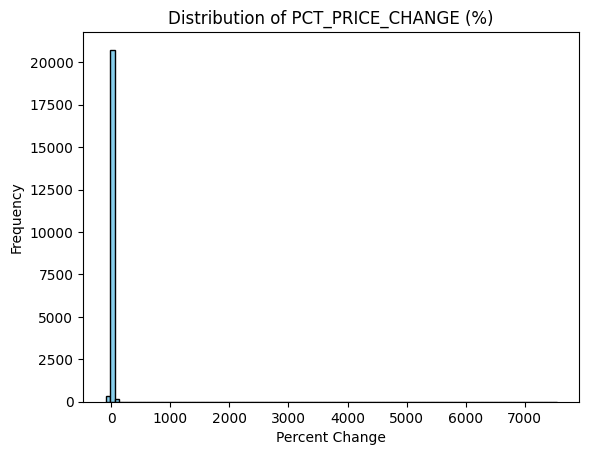

In [229]:
import matplotlib.pyplot as plt

# Histogram of PCT_PRICE_CHANGE (%) with all values
plt.hist(merged_data["PCT_PRICE_CHANGE (%)"], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of PCT_PRICE_CHANGE (%)")
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.show()


In [230]:
# Show the top 5 highest % changes
print("Largest % increases:")
print(merged_data["PCT_PRICE_CHANGE (%)"].sort_values(ascending=False).head())

# Show the bottom 5 lowest % changes
print("\nLargest % decreases:")
print(merged_data["PCT_PRICE_CHANGE (%)"].sort_values().head())


Largest % increases:
1090    7539.76
547     5666.58
9996     832.40
12192    633.95
13513    585.07
Name: PCT_PRICE_CHANGE (%), dtype: float64

Largest % decreases:
18437   -94.57
7279    -93.55
5897    -89.59
3040    -87.13
18611   -86.21
Name: PCT_PRICE_CHANGE (%), dtype: float64


In [231]:
# Define a reasonable threshold (e.g., anything > 200% or < -200%)
threshold = 200

# Subset rows where the percent change is extreme
extreme_outliers = merged_data[
    (merged_data["PCT_PRICE_CHANGE (%)"] > threshold) |
    (merged_data["PCT_PRICE_CHANGE (%)"] < -threshold)
]

# Show relevant columns
extreme_outliers = extreme_outliers[["ZIP_CODE", "YEAR", "PRICE", "NEXT_YEAR_PRICE", "PCT_PRICE_CHANGE (%)"]]

# Display

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
extreme_outliers_sorted = extreme_outliers.sort_values("PCT_PRICE_CHANGE (%)", ascending=False)
extreme_outliers_sorted.shape

#extreme_outliers_sorted

(22, 5)

In [232]:
# Remove extreme outliers from the full merged dataset
threshold = 100
mask_extreme = (merged_data["PCT_PRICE_CHANGE (%)"].abs() > threshold)
merged_data= merged_data[~mask_extreme].copy()


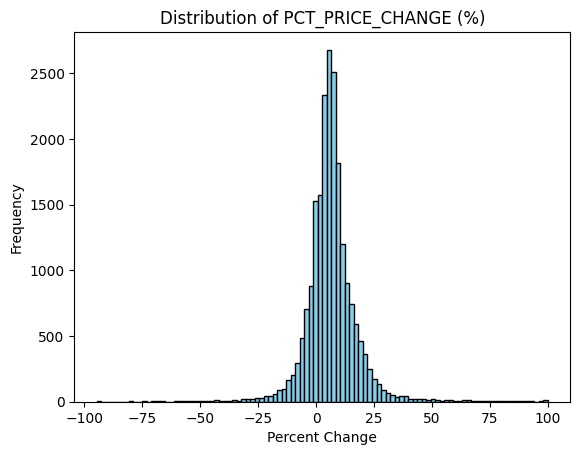

In [233]:
import matplotlib.pyplot as plt

# Histogram of PCT_PRICE_CHANGE (%) with all values
plt.hist(merged_data["PCT_PRICE_CHANGE (%)"], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of PCT_PRICE_CHANGE (%)")
plt.xlabel("Percent Change")
plt.ylabel("Frequency")
plt.show()


In [234]:
# Fill 
merged_data.shape # we lost 1800 ish rows

(21192, 25)

In [235]:
# Drop merge indicator and other useless columns
col_drop = ["_merge", "YEAR_"]
merged_data.drop(columns=col_drop, inplace=True)
# Reset index for modeling
merged_data.reset_index(drop=True, inplace=True)

merged_data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,Asian_Portion,NUM_FIRES,TOTAL_ACRES_BURNED_IN_ZIP,AVG_FIRE_DURATION_DAYS,MAX_PCT_ZIP_BURNED,ANY_MAJOR_FIRE,FIRE_EXPOSED,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%)
0,35658.00,54480,263100.00,4.24,0.41,90001,2012,89.37,30.63,16.68,...,0.15,NaN,NaN,NaN,NaN,NaN,0,249600.00,-13500.00,-5.13
1,35097.00,54760,249600.00,4.23,0.41,90001,2013,87.75,32.06,17.06,...,0.14,NaN,NaN,NaN,NaN,NaN,0,241800.00,-7800.00,-3.12
2,34050.00,56314,241800.00,4.22,0.42,90001,2014,87.02,33.64,18.10,...,0.15,NaN,NaN,NaN,NaN,NaN,0,258500.00,16700.00,6.91
3,33887.00,57227,258500.00,4.25,0.42,90001,2015,87.33,32.52,17.48,...,0.17,NaN,NaN,NaN,NaN,NaN,0,272200.00,13700.00,5.30
4,34323.00,57942,272200.00,4.26,0.42,90001,2016,87.72,32.68,18.82,...,0.17,NaN,NaN,NaN,NaN,NaN,0,305500.00,33300.00,12.23


In [236]:
########################################### Adding the time series features and burn features to improve model ########################################


# Adding features

# Rolling averages (commenting them out cause we lose to much data)
# Rolling average of price change over the last 1 year (excluding current)
merged_data["ROLLING_1yr_PRICE_CHANGE"] = merged_data.groupby("ZIP_CODE")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(1).mean()
# Rolling average of price change over the last 2 years (excluding current): Smooths short-term volatility to identify trends
#df["ROLLING_2yr_PRICE_CHANGE"] = df.groupby("ZipCode")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(2).mean() we lose too much data

# Lag price-related features
merged_data['HOME_PRICE_LAG1'] = merged_data.groupby('ZIP_CODE')['PRICE'].shift(1)
merged_data['PRICE_CHANGE_LAG1'] = merged_data.groupby('ZIP_CODE')['PRICE_CHANGE'].shift(1)
merged_data['PRICE_CHANGE_DIFF'] = merged_data['PRICE_CHANGE'] - merged_data['PRICE_CHANGE_LAG1']

# What it is: Max % of ZIP burned from the previous year.
# Why: Fires may have a lagged effect on market prices — impact might show up the year after.
merged_data['PREV_MAX_PCT_ZIP_BURNED'] = merged_data.groupby('ZIP_CODE')['MAX_PCT_ZIP_BURNED'].shift(1)

# Post-fire year: fire happened in the previous year
merged_data['FIRE_LAST_YEAR'] = merged_data.groupby('ZIP_CODE')['ANY_MAJOR_FIRE'].shift(1).fillna(0).astype(int)

# Fire shock indicator: 1 if ZIP had 2+ fires in a year (unusually high fire activity).
# Based on domain logic and histogram — most ZIP-years have 0–1 fire, so 2+ is a meaningful threshold.
merged_data['FIRE_SHOCK'] = (merged_data['NUM_FIRES'] >= 2).astype(int)


# Other Features Skye added

# Calculate YEAR_OF_LAST_FIRE for each ZIP
merged_data['YEAR_OF_LAST_FIRE'] = (
    merged_data
    .loc[merged_data['FIRE_EXPOSED'] == 1]
    .groupby('ZIP_CODE')['YEAR']
    .transform('max')
)

# Calculate YEARS_SINCE_LAST_FIRE
merged_data['YEARS_SINCE_LAST_FIRE'] = merged_data['YEAR'] - merged_data['YEAR_OF_LAST_FIRE']
#merged_data['YEARS_SINCE_LAST_FIRE'] = merged_data['YEARS_SINCE_LAST_FIRE'].fillna(-1) (do not fill na)

# Cumulative acres burned over last 2 years (SAFE shift before rolling)
merged_data['CUMULATIVE_ACRES_BURNED_LAST_3YRS'] = (
    merged_data
    .groupby('ZIP_CODE')['TOTAL_ACRES_BURNED_IN_ZIP']
    .transform(lambda x: x.shift(1).rolling(window=2, min_periods=1).sum())
)
merged_data['CUMULATIVE_ACRES_BURNED_LAST_3YRS'] = merged_data['CUMULATIVE_ACRES_BURNED_LAST_3YRS'].fillna(0)

# Interaction Features
merged_data['FIRE_EXPOSED_x_PRICE_CHANGE_LAG1'] = merged_data['FIRE_EXPOSED'] * merged_data['PRICE_CHANGE_LAG1']
merged_data['MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE'] = merged_data['MAX_PCT_ZIP_BURNED'] * merged_data['ROLLING_1yr_PRICE_CHANGE']
merged_data['MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE'] = merged_data['MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE'].fillna(0)
merged_data['FIRE_EXPOSED_x_Median_Household_Income'] = merged_data['FIRE_EXPOSED'] * merged_data['Median_Household_Income']
merged_data['FIRE_EXPOSED_x_Below_Poverty_Rate'] = merged_data['FIRE_EXPOSED'] * merged_data['Below_Poverty_Rate']

# Rolling standard deviation of 3-year price changes (SAFE shift before rolling)
merged_data['ROLLING_3yr_PRICE_CHANGE_STD'] = (
    merged_data
    .groupby('ZIP_CODE')['PCT_PRICE_CHANGE (%)']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())
)
merged_data['ROLLING_3yr_PRICE_CHANGE_STD'] = merged_data['ROLLING_3yr_PRICE_CHANGE_STD'].fillna(0)



In [237]:
#  Replace wildfire NAs with meaningful values: replace it with 0 cause it simply never happened

# Define fire-related columns where NaN should be treated as 0 (no exposure)
fill_0 = [
    'NUM_FIRES',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'PREV_MAX_PCT_ZIP_BURNED',
    'ANY_MAJOR_FIRE',
    'FIRE_LAST_YEAR',
    "MAX_PCT_ZIP_BURNED",
]

# Replace NaNs with 0 for those columns
merged_data[fill_0] = merged_data[fill_0].fillna(0)

merged_data.head()

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,FIRE_LAST_YEAR,FIRE_SHOCK,YEAR_OF_LAST_FIRE,YEARS_SINCE_LAST_FIRE,CUMULATIVE_ACRES_BURNED_LAST_3YRS,FIRE_EXPOSED_x_PRICE_CHANGE_LAG1,MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE,FIRE_EXPOSED_x_Median_Household_Income,FIRE_EXPOSED_x_Below_Poverty_Rate,ROLLING_3yr_PRICE_CHANGE_STD
0,35658.00,54480,263100.00,4.24,0.41,90001,2012,89.37,30.63,16.68,...,0,0,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00
1,35097.00,54760,249600.00,4.23,0.41,90001,2013,87.75,32.06,17.06,...,0,0,NaN,NaN,0.00,-0.00,0.00,0.00,0.00,0.00
2,34050.00,56314,241800.00,4.22,0.42,90001,2014,87.02,33.64,18.10,...,0,0,NaN,NaN,0.00,-0.00,0.00,0.00,0.00,1.42
3,33887.00,57227,258500.00,4.25,0.42,90001,2015,87.33,32.52,17.48,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,6.45
4,34323.00,57942,272200.00,4.26,0.42,90001,2016,87.72,32.68,18.82,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,5.39


In [238]:
merged_data.isna().sum()

Median_Household_Income                             25
Total_Population                                     0
PRICE                                                0
Avg_Household_Size                                   0
Gini_Index                                           0
ZIP_CODE                                             0
YEAR                                                 0
Employment_Rate                                     11
Below_Poverty_Rate                                   0
Rate_College_or_Higher                               0
Black_Portion                                        0
White_Portion                                        0
American_Indian_and_Alaska_Native_Portion            0
Asian_Portion                                        0
NUM_FIRES                                            0
TOTAL_ACRES_BURNED_IN_ZIP                            0
AVG_FIRE_DURATION_DAYS                               0
MAX_PCT_ZIP_BURNED                                   0
ANY_MAJOR_

In [239]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21192 entries, 0 to 21191
Data columns (total 38 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Median_Household_Income                        21167 non-null  float64
 1   Total_Population                               21192 non-null  int64  
 2   PRICE                                          21192 non-null  float64
 3   Avg_Household_Size                             21192 non-null  float64
 4   Gini_Index                                     21192 non-null  float64
 5   ZIP_CODE                                       21192 non-null  object 
 6   YEAR                                           21192 non-null  int64  
 7   Employment_Rate                                21181 non-null  float64
 8   Below_Poverty_Rate                             21192 non-null  float64
 9   Rate_College_or_Higher                         211

In [240]:
# FINAL XGBOOST DATA
Xgboost_data = merged_data.copy()

# Save cleaned fire data
Xgboost_data.to_csv("xgboost_data.csv", index=False)


In [241]:
Xgboost_data.head(20)

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,FIRE_LAST_YEAR,FIRE_SHOCK,YEAR_OF_LAST_FIRE,YEARS_SINCE_LAST_FIRE,CUMULATIVE_ACRES_BURNED_LAST_3YRS,FIRE_EXPOSED_x_PRICE_CHANGE_LAG1,MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE,FIRE_EXPOSED_x_Median_Household_Income,FIRE_EXPOSED_x_Below_Poverty_Rate,ROLLING_3yr_PRICE_CHANGE_STD
0,35658.00,54480,263100.00,4.24,0.41,90001,2012,89.37,30.63,16.68,...,0,0,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00
1,35097.00,54760,249600.00,4.23,0.41,90001,2013,87.75,32.06,17.06,...,0,0,NaN,NaN,0.00,-0.00,0.00,0.00,0.00,0.00
2,34050.00,56314,241800.00,4.22,0.42,90001,2014,87.02,33.64,18.10,...,0,0,NaN,NaN,0.00,-0.00,0.00,0.00,0.00,1.42
3,33887.00,57227,258500.00,4.25,0.42,90001,2015,87.33,32.52,17.48,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,6.45
4,34323.00,57942,272200.00,4.26,0.42,90001,2016,87.72,32.68,18.82,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,5.39
5,35660.00,58738,305500.00,4.25,0.42,90001,2017,88.81,31.85,19.52,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,3.63
6,38521.00,58975,336100.00,4.26,0.42,90001,2018,90.33,28.75,20.54,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,3.54
7,43360.00,59832,359000.00,4.37,0.41,90001,2019,91.34,25.56,22.37,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,2.72
8,48011.00,58974,391800.00,4.30,0.40,90001,2020,91.51,23.80,6.30,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1.65
9,52806.00,58245,425200.00,4.33,0.42,90001,2021,90.14,22.23,6.59,...,0,0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1.20
